In [35]:
import fastf1
from fastf1 import plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from matplotlib.ticker import FuncFormatter, MultipleLocator
import json

CACHE_DIR = './fastf1_cache'
if not os.path.exists(CACHE_DIR):
    os.makedirs(CACHE_DIR)
print(f"FastF1 cache enabled at: {os.path.abspath(CACHE_DIR)}")


BASE_PLOT_DIR = './f1_plots'
if not os.path.exists(BASE_PLOT_DIR):
    os.makedirs(BASE_PLOT_DIR)
print(f"Base directory for saving plots: {os.path.abspath(BASE_PLOT_DIR)}")

COMPOUND_COLORS = fastf1.plotting.COMPOUND_COLORS


FastF1 cache enabled at: c:\Users\mpoli\Desktop\UFOP\9 PERIODO\TCC\Scripts\fastf1_cache
Base directory for saving plots: c:\Users\mpoli\Desktop\UFOP\9 PERIODO\TCC\Scripts\f1_plots


C:\Users\mpoli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\fastf1\plotting\__init__.py:84: FutureWarning: INCOMPATIBLE with 2025 season! COMPOUND_COLORS is deprecated and will be removed in a future version.
  warnings.warn(f"INCOMPATIBLE with 2025 season! {name} is deprecated "


In [36]:
import pandas as pd
import json
import fastf1

# --- Configurações Iniciais ---
start_year_analysis = 2019
end_year_analysis = 2026 

all_results_data = {}
all_laps_data = {}
all_weather_data = {}
all_event_metadata = {} 

json_path = 'compounds.json'
try:
    with open(json_path, 'r') as file:
        compounds_data = json.load(file)
    print(f"Arquivo '{json_path}' carregado com sucesso.")
except FileNotFoundError:
    print(f"AVISO: '{json_path}' não encontrado. O mapeamento de 'pirelliCompound' será pulado.")
    compounds_data = {'data': {}} 


print(f"\n--- Iniciando coleta de dados de TODOS os GPs de {start_year_analysis} até {end_year_analysis-1} ---")

# --- 2. Loop Externo (ANO) ---
for year in range(start_year_analysis, end_year_analysis):
    print(f"\n--- Processando Temporada: {year} ---")
    
    all_results_data[year] = {}
    all_laps_data[year] = {}
    all_weather_data[year] = {}
    all_event_metadata[year] = {}
    
    try:
        schedule = fastf1.get_event_schedule(year)
    except Exception as e:
        print(f"  ERRO: Não foi possível obter o calendário de {year}. Pulando o ano. Detalhes: {e}")
        continue

    for index, event_row in schedule.iterrows():
        
        if event_row['EventFormat'] not in ['conventional', 'sprint', 'sprint_shootout', 'sprint_qualifying']:
            print(f"  Skipping '{event_row['EventName']}' (Formato: {event_row['EventFormat']})")
            continue
            
        round_num = event_row['RoundNumber']
        actual_event_name = event_row['EventName']
        country = event_row['Country']
        city = event_row['Location'] 

        print(f"  -> Carregando R{round_num}: {actual_event_name} ({city}, {country})")

        if pd.Timestamp.now(tz='UTC') < event_row['Session5Date']:
            print(f"     AVISO: Evento R{round_num} ({actual_event_name}) está no futuro. Pulando.")
            continue
            
        try:
            session = fastf1.get_session(year, round_num, 'R') 
            session.load(laps=True, telemetry=False, weather=True, messages=True) 
        except Exception as e:
            print(f"     ERRO: Falha ao carregar dados da sessão R{round_num}. Pulando. Detalhes: {e}")
            continue

        if session.laps is None or session.laps.empty:
            print(f"     AVISO: Sessão R{round_num} não contém dados de voltas (session.laps). Pulando.")
            continue
            
        laps_df = session.laps.copy()
        results_df = session.results.copy()
        
        if 'LapTime_seconds' not in laps_df.columns:
            laps_df['LapTime_seconds'] = laps_df['LapTime'].dt.total_seconds()

        year_str = str(year)
        if year_str in compounds_data['data']:
            gp_compound_mapping = compounds_data['data'][year_str].get(actual_event_name) 

            if gp_compound_mapping:
                laps_df['pirelliCompound'] = laps_df['Compound'].map(gp_compound_mapping)
                laps_df['pirelliCompound'] = laps_df['pirelliCompound'].fillna(laps_df['Compound'])
            else:
                print(f"     AVISO: Mapeamento de compostos não encontrado no JSON para '{actual_event_name}' em {year}.")
                laps_df['pirelliCompound'] = laps_df['Compound']
        else:
            print(f"     AVISO: Ano {year} não encontrado no 'compounds.json'.")
            laps_df['pirelliCompound'] = laps_df['Compound']

        all_results_data[year][round_num] = results_df
        all_laps_data[year][round_num] = laps_df
        all_weather_data[year][round_num] = session.weather_data
        
        all_event_metadata[year][round_num] = {
            'EventName': actual_event_name,
            'Country': country,
            'City': city,
            'Date': session.date
        }
        
        print(f"     Dados de R{round_num} {year} carregados. (Total de Voltas: {len(laps_df)})")
        
    print(f"--- Temporada {year} concluída. ---")

print("\n--- Coleta de dados completa. ---")
print(f"Anos coletados: {list(all_laps_data.keys())}")

Arquivo 'compounds.json' carregado com sucesso.

--- Iniciando coleta de dados de TODOS os GPs de 2019 até 2025 ---

--- Processando Temporada: 2019 ---


core           INFO 	Loading data for Australian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


  -> Carregando R1: Australian Grand Prix (Melbourne, Australia)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	Driver 16: Lap timing integrity check failed for 1 lap(s)
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 77 completed the race distance 00:00.387000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['77', '44', '33', '5', '16', '20', '27', '7', '18', '26', '10', '4', '11', '23', '99', '63', '88', '8', '3', '55']
core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached da

     Dados de R1 2019 carregados. (Total de Voltas: 1041)
  -> Carregando R2: Bahrain Grand Prix (Sakhir, Bahrain)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 44 completed the race distance 00:00.070000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['44', '77', '16', '33', '5', '4', '7', '10', '23', '11', '99', '26', '20', '18', '63', '88', '27', '3', '55', '8']
core           INFO 	Loading data for Chinese Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


     Dados de R2 2019 carregados. (Total de Voltas: 1083)
  -> Carregando R3: Chinese Grand Prix (Shanghai, China)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 44 completed the race distance 00:00.423000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['44', '77', '5', '33', '16', '10', '3', '11', '7', '23', '8', '18', '20', '55', '99', '63', '88', '4', '26', '27']
core           INFO 	Loading data for Azerbaijan Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


     Dados de R3 2019 carregados. (Total de Voltas: 1046)
  -> Carregando R4: Azerbaijan Grand Prix (Baku, Azerbaijan)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 77 completed the race distance 00:00.075000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['77', '44', '5', '33', '16', '11', '55', '4', '18', '7', '23', '99', '20', '27', '63', '88', '10', '8', '26', '3']
core           INFO 	Loading data for Spanish Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


     Dados de R4 2019 carregados. (Total de Voltas: 948)
  -> Carregando R5: Spanish Grand Prix (Barcelona, Spain)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 44 completed the race distance 00:00.059000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['44', '77', '33', '5', '16', '10', '20', '55', '26', '8', '23', '3', '27', '7', '11', '99', '63', '88', '18', '4']
core           INFO 	Loading data for Monaco Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


     Dados de R5 2019 carregados. (Total de Voltas: 1276)
  -> Carregando R6: Monaco Grand Prix (Monte Carlo, Monaco)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 44 completed the race distance 00:00.087000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['44', '5', '77', '33', '10', '55', '26', '23', '3', '8', '4', '11', '27', '20', '63', '18', '7', '88', '99', '16']
core           INFO 	Loading data for Canadian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


     Dados de R6 2019 carregados. (Total de Voltas: 1490)
  -> Carregando R7: Canadian Grand Prix (Montréal, Canada)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 5 completed the race distance 00:00.190000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['44', '5', '16', '77', '33', '3', '27', '10', '18', '26', '55', '11', '99', '8', '7', '63', '20', '88', '23', '4']
core           INFO 	Loading data for French Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


     Dados de R7 2019 carregados. (Total de Voltas: 1312)
  -> Carregando R8: French Grand Prix (Le Castellet, France)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	Driver 27: Lap timing integrity check failed for 1 lap(s)
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 44 completed the race distance 00:00.126000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['44', '77', '16', '33', '5', '55', '7', '27', '4', '10', '3', '11', '18', '26', '23', '99', '20', '88', '63', '8']
core           INFO 	Loading data for Austrian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached d

     Dados de R8 2019 carregados. (Total de Voltas: 1037)
  -> Carregando R9: Austrian Grand Prix (Spielberg, Austria)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 33 completed the race distance 00:00.042000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['33', '16', '77', '5', '44', '4', '10', '55', '7', '99', '11', '3', '27', '18', '23', '8', '26', '63', '20', '88']
core           INFO 	Loading data for British Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


     Dados de R9 2019 carregados. (Total de Voltas: 1401)
  -> Carregando R10: British Grand Prix (Silverstone, Great Britain)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 44 completed the race distance 00:00.042000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['44', '77', '16', '10', '33', '55', '3', '7', '26', '27', '4', '23', '18', '63', '88', '5', '11', '99', '8', '20']
core           INFO 	Loading data for German Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


     Dados de R10 2019 carregados. (Total de Voltas: 914)
  -> Carregando R11: German Grand Prix (Hockenheim, Germany)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 33 completed the race distance 00:00.090000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['33', '5', '26', '18', '55', '23', '8', '20', '44', '88', '63', '7', '99', '10', '77', '27', '16', '4', '3', '11']
core           INFO 	Loading data for Hungarian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


     Dados de R11 2019 carregados. (Total de Voltas: 1059)
  -> Carregando R12: Hungarian Grand Prix (Budapest, Hungary)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 44 completed the race distance 00:00.069000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['44', '33', '5', '16', '55', '10', '7', '77', '4', '23', '11', '27', '20', '3', '26', '63', '18', '99', '88', '8']
core           INFO 	Loading data for Belgian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


     Dados de R12 2019 carregados. (Total de Voltas: 1358)
  -> Carregando R13: Belgian Grand Prix (Spa-Francorchamps, Belgium)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 16 completed the race distance 00:00.211000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['16', '44', '77', '5', '23', '11', '26', '27', '10', '18', '4', '20', '8', '3', '63', '7', '88', '99', '55', '33']
core           INFO 	Loading data for Italian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


     Dados de R13 2019 carregados. (Total de Voltas: 787)
  -> Carregando R14: Italian Grand Prix (Monza, Italy)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 16 completed the race distance 00:00.092000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['16', '77', '44', '3', '27', '23', '11', '33', '99', '4', '10', '18', '5', '63', '7', '8', '88', '20', '26', '55']
core           INFO 	Loading data for Singapore Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


     Dados de R14 2019 carregados. (Total de Voltas: 991)
  -> Carregando R15: Singapore Grand Prix (Singapore, Singapore)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	Driver 18: Lap timing integrity check failed for 1 lap(s)
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 5 completed the race distance 00:00.171000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['5', '16', '33', '44', '77', '23', '4', '10', '27', '99', '8', '55', '18', '3', '26', '88', '20', '7', '11', '63']
core           INFO 	Loading data for Russian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached dat

     Dados de R15 2019 carregados. (Total de Voltas: 1165)
  -> Carregando R16: Russian Grand Prix (Sochi, Russia)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 44 completed the race distance 00:00.308000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['44', '77', '16', '33', '23', '55', '11', '4', '20', '27', '18', '26', '7', '10', '99', '88', '63', '5', '3', '8']
core           INFO 	Loading data for Japanese Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


     Dados de R16 2019 carregados. (Total de Voltas: 901)
  -> Carregando R17: Japanese Grand Prix (Suzuka, Japan)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 77 completed the race distance 00:00.224000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['77', '5', '44', '23', '55', '16', '10', '11', '18', '26', '4', '7', '8', '99', '20', '63', '88', '33', '3', '27']
core           INFO 	Loading data for Mexican Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


     Dados de R17 2019 carregados. (Total de Voltas: 1005)
  -> Carregando R18: Mexican Grand Prix (Mexico City, Mexico)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	Driver  5: Lap timing integrity check failed for 1 lap(s)
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 44 completed the race distance 00:00.798000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['44', '5', '77', '16', '23', '33', '11', '3', '10', '27', '26', '18', '55', '99', '20', '63', '8', '88', '7', '4']
core           INFO 	Loading data for United States Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cac

     Dados de R18 2019 carregados. (Total de Voltas: 1370)
  -> Carregando R19: United States Grand Prix (Austin, United States)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	Driver  4: Lap timing integrity check failed for 1 lap(s)
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 77 completed the race distance 00:00.080000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['77', '44', '33', '16', '23', '3', '4', '55', '27', '11', '7', '26', '18', '99', '8', '10', '63', '20', '88', '5']
core           INFO 	Loading data for Brazilian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached 

     Dados de R19 2019 carregados. (Total de Voltas: 1032)
  -> Carregando R20: Brazilian Grand Prix (São Paulo, Brazil)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	Driver 20: Lap timing integrity check failed for 1 lap(s)
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 33 completed the race distance 00:00.145000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['33', '10', '55', '7', '99', '3', '44', '4', '11', '26', '20', '63', '8', '23', '27', '88', '5', '16', '18', '77']
core           INFO 	Loading data for Abu Dhabi Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached 

     Dados de R20 2019 carregados. (Total de Voltas: 1385)
  -> Carregando R21: Abu Dhabi Grand Prix (Yas Island, Abu Dhabi)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	Driver  4: Lap timing integrity check failed for 1 lap(s)
core        WARNING 	Driver 55: Lap timing integrity check failed for 1 lap(s)
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '33', '16', '77', '5', '23', '11', '4', '26', '55', '3', '27', '7', '20', '8', '99', '63', '10', '88', '18']


     Dados de R21 2019 carregados. (Total de Voltas: 1075)
--- Temporada 2019 concluída. ---

--- Processando Temporada: 2020 ---


core           INFO 	Loading data for Austrian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


  Skipping 'Pre-Season Test 1' (Formato: testing)
  Skipping 'Pre-Season Test 2' (Formato: testing)
  -> Carregando R1: Austrian Grand Prix (Spielberg, Austria)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	Driver 77: Lap timing integrity check failed for 1 lap(s)
core        WARNING 	Driver 16: Lap timing integrity check failed for 1 lap(s)
core        WARNING 	Driver  4: Lap timing integrity check failed for 1 lap(s)
core        WARNING 	Driver 44: Lap timing integrity check failed for 1 lap(s)
core        WARNING 	Driver 55: Lap timing integrity check failed for 1 lap(s)
core        WARNING 	Driver 11: Lap timing integrity check failed for 1 lap(s)
core        WARNING 	Driver 10: Lap timing integrity check failed for 1 lap(s)
core        WARNING 	Driver 31: Lap timing integrity check failed for 1 lap(s)
core        WARNING 

     Dados de R1 2020 carregados. (Total de Voltas: 1052)
  -> Carregando R2: Styrian Grand Prix (Spielberg, Austria)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 44 completed the race distance 00:00.057000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['44', '77', '33', '23', '4', '11', '18', '3', '55', '26', '7', '20', '8', '99', '10', '63', '6', '31', '16', '5']
core           INFO 	Loading data for Hungarian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


     Dados de R2 2020 carregados. (Total de Voltas: 1226)
  -> Carregando R3: Hungarian Grand Prix (Budapest, Hungary)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 44 completed the race distance 00:00.098000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['44', '33', '77', '18', '23', '5', '11', '3', '55', '20', '16', '26', '4', '31', '7', '8', '99', '63', '6', '10']
core           INFO 	Loading data for British Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


     Dados de R3 2020 carregados. (Total de Voltas: 1327)
  -> Carregando R4: British Grand Prix (Silverstone, Great Britain)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '33', '16', '3', '4', '31', '10', '23', '18', '5', '77', '63', '55', '99', '6', '8', '7', '26', '20', '27']
core           INFO 	Loading data for 70th Anniversary Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


     Dados de R4 2020 carregados. (Total de Voltas: 898)
  -> Carregando R5: 70th Anniversary Grand Prix (Silverstone, Great Britain)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 33 completed the race distance 00:00.036000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['33', '44', '77', '16', '23', '18', '27', '31', '4', '26', '10', '5', '55', '3', '7', '8', '99', '63', '6', '20']
core           INFO 	Loading data for Spanish Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


     Dados de R5 2020 carregados. (Total de Voltas: 1025)
  -> Carregando R6: Spanish Grand Prix (Barcelona, Spain)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 44 completed the race distance 00:00.071000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['44', '33', '77', '18', '11', '55', '5', '23', '10', '4', '3', '26', '31', '7', '20', '99', '63', '6', '8', '16']
core           INFO 	Loading data for Belgian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


     Dados de R6 2020 carregados. (Total de Voltas: 1274)
  -> Carregando R7: Belgian Grand Prix (Spa-Francorchamps, Belgium)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 44 completed the race distance 00:00.105000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['44', '77', '33', '3', '31', '23', '4', '10', '18', '11', '26', '7', '5', '16', '8', '6', '20', '99', '63', '55']
core           INFO 	Loading data for Italian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


     Dados de R7 2020 carregados. (Total de Voltas: 769)
  -> Carregando R8: Italian Grand Prix (Monza, Italy)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 10 completed the race distance 00:00.067000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['10', '55', '18', '4', '77', '3', '44', '31', '26', '11', '6', '8', '7', '63', '23', '99', '33', '16', '20', '5']
core           INFO 	Loading data for Tuscan Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


     Dados de R8 2020 carregados. (Total de Voltas: 926)
  -> Carregando R9: Tuscan Grand Prix (Mugello, Italy)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 44 completed the race distance 00:00.070000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['44', '77', '23', '3', '11', '4', '26', '16', '7', '5', '63', '8', '18', '31', '6', '20', '99', '55', '33', '10']
core           INFO 	Loading data for Russian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


     Dados de R9 2020 carregados. (Total de Voltas: 786)
  -> Carregando R10: Russian Grand Prix (Sochi, Russia)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 77 completed the race distance 00:00.039000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['77', '33', '44', '11', '3', '16', '31', '26', '10', '23', '99', '20', '5', '7', '4', '6', '8', '63', '55', '18']
core           INFO 	Loading data for Eifel Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


     Dados de R10 2020 carregados. (Total de Voltas: 948)
  -> Carregando R11: Eifel Grand Prix (Nürburgring, Germany)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 44 completed the race distance 00:00.016000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['44', '33', '3', '11', '55', '10', '16', '27', '8', '99', '5', '7', '20', '6', '26', '4', '23', '31', '77', '63']
core           INFO 	Loading data for Portuguese Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


     Dados de R11 2020 carregados. (Total de Voltas: 1019)
  -> Carregando R12: Portuguese Grand Prix (Portimão, Portugal)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 44 completed the race distance 00:00.098000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['44', '77', '33', '16', '10', '55', '11', '31', '3', '5', '7', '23', '4', '63', '99', '20', '8', '6', '26', '18']
core           INFO 	Loading data for Emilia Romagna Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


     Dados de R12 2020 carregados. (Total de Voltas: 1288)
  -> Carregando R13: Emilia Romagna Grand Prix (Imola, Italy)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	Driver 23: Lap timing integrity check failed for 1 lap(s)
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 44 completed the race distance 00:00.100000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['44', '77', '3', '26', '16', '11', '55', '4', '7', '99', '6', '5', '18', '8', '23', '63', '33', '20', '31', '10']
core           INFO 	Loading data for Turkish Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached dat

     AVISO: Mapeamento de compostos não encontrado no JSON para 'Emilia Romagna Grand Prix' em 2020.
     Dados de R13 2020 carregados. (Total de Voltas: 1131)
  -> Carregando R14: Turkish Grand Prix (Istanbul, Turkey)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 44 completed the race distance 00:00.068000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['44', '11', '5', '16', '55', '33', '23', '4', '18', '3', '31', '26', '10', '77', '7', '63', '20', '8', '6', '99']
core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


     Dados de R14 2020 carregados. (Total de Voltas: 1077)
  -> Carregando R15: Bahrain Grand Prix (Sakhir, Bahrain)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '33', '23', '4', '55', '10', '3', '77', '31', '16', '26', '63', '5', '6', '7', '99', '20', '11', '18', '8']
core           INFO 	Loading data for Sakhir Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


     Dados de R15 2020 carregados. (Total de Voltas: 1019)
  -> Carregando R16: Sakhir Grand Prix (Sakhir, Bahrain)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 11 completed the race distance 00:00.111000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['11', '31', '18', '55', '3', '23', '26', '77', '63', '4', '10', '5', '99', '7', '20', '89', '51', '6', '33', '16']
core           INFO 	Loading data for Abu Dhabi Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


     Dados de R16 2020 carregados. (Total de Voltas: 1534)
  -> Carregando R17: Abu Dhabi Grand Prix (Yas Island, Abu Dhabi)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	Driver  6: Lap timing integrity check failed for 1 lap(s)
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 33 completed the race distance 00:00.087000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['33', '77', '44', '23', '4', '55', '3', '10', '31', '18', '26', '7', '16', '5', '63', '99', '6', '20', '51', '11']


     Dados de R17 2020 carregados. (Total de Voltas: 1044)
--- Temporada 2020 concluída. ---

--- Processando Temporada: 2021 ---


core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


  Skipping 'Pre-Season Test' (Formato: testing)
  -> Carregando R1: Bahrain Grand Prix (Sakhir, Bahrain)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 44 completed the race distance 00:00.067000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['44', '33', '77', '4', '11', '16', '3', '55', '22', '18', '7', '99', '31', '63', '5', '47', '10', '6', '14', '9']
core           INFO 	Loading data for Emilia Romagna Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


     Dados de R1 2021 carregados. (Total de Voltas: 1027)
  -> Carregando R2: Emilia Romagna Grand Prix (Imola, Italy)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 33 completed the race distance 00:01.003000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['33', '44', '4', '16', '55', '3', '10', '18', '31', '14', '11', '22', '7', '99', '5', '47', '9', '77', '63', '6']
core           INFO 	Loading data for Portuguese Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


     AVISO: Mapeamento de compostos não encontrado no JSON para 'Emilia Romagna Grand Prix' em 2021.
     Dados de R2 2021 carregados. (Total de Voltas: 1127)
  -> Carregando R3: Portuguese Grand Prix (Portimão, Portugal)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 44 completed the race distance 00:00.050000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['44', '33', '77', '11', '4', '16', '31', '14', '3', '10', '55', '99', '5', '18', '22', '63', '47', '6', '9', '7']
core           INFO 	Loading data for Spanish Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


     Dados de R3 2021 carregados. (Total de Voltas: 1245)
  -> Carregando R4: Spanish Grand Prix (Barcelona, Spain)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 44 completed the race distance 00:00.083000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['44', '33', '77', '16', '11', '3', '55', '4', '31', '10', '18', '7', '5', '63', '99', '6', '14', '47', '9', '22']
core           INFO 	Loading data for Monaco Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


     Dados de R4 2021 carregados. (Total de Voltas: 1247)
  -> Carregando R5: Monaco Grand Prix (Monte Carlo, Monaco)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 33 completed the race distance 00:00.058000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['33', '55', '4', '11', '5', '10', '44', '18', '31', '99', '7', '3', '14', '63', '6', '22', '9', '47', '77', '16']
core           INFO 	Loading data for Azerbaijan Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


     Dados de R5 2021 carregados. (Total de Voltas: 1420)
  -> Carregando R6: Azerbaijan Grand Prix (Baku, Azerbaijan)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 11 completed the race distance 00:00.028000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['11', '5', '10', '16', '4', '14', '22', '55', '3', '7', '99', '77', '47', '9', '44', '6', '63', '33', '18', '31']
core           INFO 	Loading data for French Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


     Dados de R6 2021 carregados. (Total de Voltas: 943)
  -> Carregando R7: French Grand Prix (Le Castellet, France)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 33 completed the race distance 00:00.047000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['33', '44', '11', '77', '4', '3', '10', '14', '5', '18', '55', '63', '22', '31', '99', '16', '7', '6', '47', '9']
core           INFO 	Loading data for Styrian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


     Dados de R7 2021 carregados. (Total de Voltas: 1051)
  -> Carregando R8: Styrian Grand Prix (Spielberg, Austria)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 33 completed the race distance 00:00.152000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['33', '44', '77', '11', '4', '55', '16', '18', '14', '22', '7', '5', '3', '31', '99', '47', '6', '9', '63', '10']
core           INFO 	Loading data for Austrian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


     Dados de R8 2021 carregados. (Total de Voltas: 1296)
  -> Carregando R9: Austrian Grand Prix (Spielberg, Austria)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 33 completed the race distance 00:00.061000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['33', '77', '4', '44', '55', '11', '3', '16', '10', '14', '63', '22', '18', '99', '7', '6', '5', '47', '9', '31']
core           INFO 	Loading data for British Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


     Dados de R9 2021 carregados. (Total de Voltas: 1338)
  -> Carregando R10: British Grand Prix (Silverstone, Great Britain)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 44 completed the race distance 00:00.025000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['44', '16', '77', '4', '3', '55', '14', '18', '31', '22', '10', '63', '99', '6', '7', '11', '9', '47', '5', '33']
core           INFO 	Loading data for Hungarian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


     Dados de R10 2021 carregados. (Total de Voltas: 970)
  -> Carregando R11: Hungarian Grand Prix (Budapest, Hungary)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 31 completed the race distance 00:00.068000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['31', '44', '55', '14', '10', '22', '6', '63', '33', '7', '3', '47', '99', '9', '4', '77', '11', '16', '18', '5']
core           INFO 	Loading data for Belgian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


     Dados de R11 2021 carregados. (Total de Voltas: 985)
  -> Carregando R12: Belgian Grand Prix (Spa-Francorchamps, Belgium)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['33', '63', '44', '3', '5', '10', '31', '16', '6', '55', '14', '77', '99', '4', '22', '47', '9', '7', '11', '18']
core           INFO 	Loading data for Dutch Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


     Dados de R12 2021 carregados. (Total de Voltas: 60)
  -> Carregando R13: Dutch Grand Prix (Zandvoort, Netherlands)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 33 completed the race distance 00:00.012000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['33', '44', '77', '10', '16', '14', '55', '11', '31', '4', '3', '18', '5', '99', '88', '6', '63', '47', '22', '9']
core           INFO 	Loading data for Italian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


     Dados de R13 2021 carregados. (Total de Voltas: 1361)
  -> Carregando R14: Italian Grand Prix (Monza, Italy)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 3 completed the race distance 00:00.086000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['3', '4', '77', '16', '11', '55', '18', '14', '63', '31', '6', '5', '99', '88', '47', '9', '44', '33', '10', '22']
core           INFO 	Loading data for Russian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


     Dados de R14 2021 carregados. (Total de Voltas: 892)
  -> Carregando R15: Russian Grand Prix (Sochi, Russia)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 44 completed the race distance 00:00.044000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['44', '33', '55', '3', '77', '14', '4', '7', '11', '63', '18', '5', '10', '31', '16', '99', '22', '9', '6', '47']
core           INFO 	Loading data for Turkish Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


     Dados de R15 2021 carregados. (Total de Voltas: 1025)
  -> Carregando R16: Turkish Grand Prix (Istanbul, Turkey)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 77 completed the race distance 00:00.079000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['77', '33', '11', '16', '44', '10', '4', '55', '18', '31', '99', '7', '3', '22', '63', '14', '6', '5', '47', '9']
core           INFO 	Loading data for United States Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


     Dados de R16 2021 carregados. (Total de Voltas: 1147)
  -> Carregando R17: United States Grand Prix (Austin, United States)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	Driver  7: Lap timing integrity check failed for 1 lap(s)
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 33 completed the race distance 00:00.059000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['33', '44', '11', '16', '3', '77', '55', '4', '22', '5', '99', '18', '7', '63', '6', '47', '9', '14', '31', '10']
core           INFO 	Loading data for Mexico City Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached

     Dados de R17 2021 carregados. (Total de Voltas: 1044)
  -> Carregando R18: Mexico City Grand Prix (Mexico City, Mexico)


req            INFO 	Using cached data for session_status_data
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for timing_app_data. Loading data...
_api           INFO 	Fetching timing app data...
req            INFO 	Data has been written to cache!
core           INFO 	Processing timing data...
req            INFO 	No cached data found for weather_data. Loading data...
_api           INFO 	Fetching weather data...
r

     AVISO: Mapeamento de compostos não encontrado no JSON para 'Mexico City Grand Prix' em 2021.
     Dados de R18 2021 carregados. (Total de Voltas: 1261)
  -> Carregando R19: São Paulo Grand Prix (São Paulo, Brazil)


req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
req            INFO 	Data has been written to cache!

     AVISO: Mapeamento de compostos não encontrado no JSON para 'São Paulo Grand Prix' em 2021.
     Dados de R19 2021 carregados. (Total de Voltas: 1360)
  -> Carregando R20: Qatar Grand Prix (Lusail, Qatar)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 44 completed the race distance 00:00.037000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['44', '33', '14', '11', '31', '18', '55', '16', '4', '5', '10', '3', '22', '7', '99', '47', '63', '9', '6', '77']
core           INFO 	Loading data for Saudi Arabian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


     Dados de R20 2021 carregados. (Total de Voltas: 1114)
  -> Carregando R21: Saudi Arabian Grand Prix (Jeddah, Saudi Arabia)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 44 completed the race distance 00:00.180000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['44', '33', '77', '31', '3', '10', '16', '55', '99', '4', '18', '6', '14', '22', '7', '5', '11', '9', '63', '47']
core           INFO 	Loading data for Abu Dhabi Grand Prix - Race [v3.5.3]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...


     Dados de R21 2021 carregados. (Total de Voltas: 845)
  -> Carregando R22: Abu Dhabi Grand Prix (Yas Island, Abu Dhabi)


req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
req            INFO 	Data has been written to cache!

     Dados de R22 2021 carregados. (Total de Voltas: 1000)
--- Temporada 2021 concluída. ---

--- Processando Temporada: 2022 ---


core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


  Skipping 'Pre-Season Track Session' (Formato: testing)
  Skipping 'Pre-Season Test' (Formato: testing)
  -> Carregando R1: Bahrain Grand Prix (Sakhir, Bahrain)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 16 completed the race distance 00:00.050000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['16', '55', '44', '63', '20', '77', '31', '22', '14', '24', '47', '18', '23', '3', '4', '6', '27', '11', '1', '10']
core           INFO 	Loading data for Saudi Arabian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


     Dados de R1 2022 carregados. (Total de Voltas: 1125)
  -> Carregando R2: Saudi Arabian Grand Prix (Jeddah, Saudi Arabia)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	No lap data for driver 22
core        WARNING 	No lap data for driver 47
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 22)
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 47)
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '16', '55', '11', '63', '31', '4', '10', '20', '44', '24', '27', '18', '23', '77', '14', '3', '6', '22', '47']
core           INFO 	Loading data for Australian Grand Pr

     Dados de R2 2022 carregados. (Total de Voltas: 820)
  -> Carregando R3: Australian Grand Prix (Melbourne, Australia)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 16 completed the race distance 00:00.140000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['16', '11', '63', '44', '4', '3', '31', '77', '10', '23', '24', '18', '47', '20', '22', '6', '14', '1', '5', '55']
core           INFO 	Loading data for Emilia Romagna Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


     Dados de R3 2022 carregados. (Total de Voltas: 1045)
  -> Carregando R4: Emilia Romagna Grand Prix (Imola, Italy)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '4', '63', '77', '16', '22', '5', '20', '18', '23', '10', '44', '31', '24', '6', '47', '3', '14', '55']
core           INFO 	Loading data for Miami Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


     AVISO: Mapeamento de compostos não encontrado no JSON para 'Emilia Romagna Grand Prix' em 2022.
     Dados de R4 2022 carregados. (Total de Voltas: 1132)
  -> Carregando R5: Miami Grand Prix (Miami, United States)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '16', '55', '11', '63', '44', '77', '31', '23', '18', '14', '22', '3', '6', '47', '20', '5', '10', '4', '24']
core           INFO 	Loading data for Spanish Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


     Dados de R5 2022 carregados. (Total de Voltas: 1057)
  -> Carregando R6: Spanish Grand Prix (Barcelona, Spain)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '63', '55', '44', '77', '31', '4', '14', '22', '5', '3', '10', '47', '18', '6', '20', '23', '24', '16']
core           INFO 	Loading data for Monaco Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


     Dados de R6 2022 carregados. (Total de Voltas: 1230)
  -> Carregando R7: Monaco Grand Prix (Monaco, Monaco)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['11', '55', '1', '16', '63', '4', '14', '44', '77', '5', '10', '31', '3', '18', '6', '24', '22', '23', '47', '20']
core           INFO 	Loading data for Azerbaijan Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


     Dados de R7 2022 carregados. (Total de Voltas: 1179)
  -> Carregando R8: Azerbaijan Grand Prix (Baku, Azerbaijan)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	Driver 16: Lap timing integrity check failed for 1 lap(s)
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '63', '44', '10', '5', '14', '3', '4', '31', '77', '23', '22', '47', '6', '18', '20', '24', '16', '55']
core           INFO 	Loading data for Canadian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


     Dados de R8 2022 carregados. (Total de Voltas: 891)
  -> Carregando R9: Canadian Grand Prix (Montréal, Canada)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '55', '44', '63', '16', '31', '77', '24', '14', '18', '3', '5', '23', '10', '4', '6', '20', '22', '47', '11']
core           INFO 	Loading data for British Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


     Dados de R9 2022 carregados. (Total de Voltas: 1264)
  -> Carregando R10: British Grand Prix (Silverstone, Great Britain)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['55', '11', '44', '16', '14', '4', '1', '47', '5', '20', '18', '6', '3', '22', '31', '10', '77', '63', '24', '23']
core           INFO 	Loading data for Austrian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


     Dados de R10 2022 carregados. (Total de Voltas: 815)
  -> Carregando R11: Austrian Grand Prix (Spielberg, Austria)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 16 completed the race distance 00:00.024000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['16', '1', '44', '63', '31', '47', '4', '20', '3', '14', '77', '23', '18', '24', '10', '22', '5', '55', '6', '11']
core           INFO 	Loading data for French Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


     Dados de R11 2022 carregados. (Total de Voltas: 1324)
  -> Carregando R12: French Grand Prix (Le Castellet, France)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 1 completed the race distance 00:00.041000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['1', '44', '63', '11', '55', '14', '4', '31', '3', '18', '5', '10', '23', '77', '47', '24', '6', '20', '16', '22']
core           INFO 	Loading data for Hungarian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


     Dados de R12 2022 carregados. (Total de Voltas: 958)
  -> Carregando R13: Hungarian Grand Prix (Budapest, Hungary)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '44', '63', '55', '11', '16', '4', '14', '31', '5', '18', '10', '24', '47', '3', '20', '23', '6', '22', '77']
core           INFO 	Loading data for Belgian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


     Dados de R13 2022 carregados. (Total de Voltas: 1383)
  -> Carregando R14: Belgian Grand Prix (Spa-Francorchamps, Belgium)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '55', '63', '14', '16', '31', '5', '10', '23', '18', '4', '22', '24', '3', '20', '47', '6', '77', '44']
core           INFO 	Loading data for Dutch Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


     Dados de R14 2022 carregados. (Total de Voltas: 792)
  -> Carregando R15: Dutch Grand Prix (Zandvoort, Netherlands)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '63', '16', '44', '11', '14', '4', '55', '31', '18', '10', '23', '47', '5', '20', '24', '3', '6', '77', '22']
core           INFO 	Loading data for Italian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


     Dados de R15 2022 carregados. (Total de Voltas: 1392)
  -> Carregando R16: Italian Grand Prix (Monza, Italy)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '16', '63', '55', '44', '11', '4', '10', '45', '24', '31', '47', '77', '22', '6', '20', '3', '18', '14', '5']
core           INFO 	Loading data for Singapore Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


     Dados de R16 2022 carregados. (Total de Voltas: 971)
  -> Carregando R17: Singapore Grand Prix (Marina Bay, Singapore)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['11', '16', '55', '4', '3', '18', '1', '5', '44', '10', '77', '20', '47', '63', '22', '31', '23', '14', '6', '24']
core           INFO 	Loading data for Japanese Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


     Dados de R17 2022 carregados. (Total de Voltas: 945)
  -> Carregando R18: Japanese Grand Prix (Suzuka, Japan)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '16', '31', '44', '5', '14', '63', '6', '4', '3', '18', '22', '20', '77', '24', '47', '10', '55', '23']
core           INFO 	Loading data for United States Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


     Dados de R18 2022 carregados. (Total de Voltas: 507)
  -> Carregando R19: United States Grand Prix (Austin, United States)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '44', '16', '11', '63', '4', '14', '5', '20', '22', '31', '24', '23', '10', '47', '3', '6', '18', '77', '55']
core           INFO 	Loading data for Mexico City Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


     Dados de R19 2022 carregados. (Total de Voltas: 992)
  -> Carregando R20: Mexico City Grand Prix (Mexico City, Mexico)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '44', '11', '63', '55', '16', '3', '31', '4', '77', '10', '23', '24', '5', '18', '47', '20', '6', '14', '22']
core           INFO 	Loading data for São Paulo Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


     AVISO: Mapeamento de compostos não encontrado no JSON para 'Mexico City Grand Prix' em 2022.
     Dados de R20 2022 carregados. (Total de Voltas: 1379)
  -> Carregando R21: São Paulo Grand Prix (São Paulo, Brazil)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['63', '44', '55', '16', '14', '1', '11', '31', '77', '18', '5', '24', '47', '10', '23', '6', '22', '4', '20', '3']
core           INFO 	Loading data for Abu Dhabi Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


     AVISO: Mapeamento de compostos não encontrado no JSON para 'São Paulo Grand Prix' em 2022.
     Dados de R21 2022 carregados. (Total de Voltas: 1259)
  -> Carregando R22: Abu Dhabi Grand Prix (Yas Island, Abu Dhabi)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '16', '11', '55', '63', '4', '31', '18', '3', '5', '22', '24', '23', '10', '77', '47', '20', '44', '6', '14']


     Dados de R22 2022 carregados. (Total de Voltas: 1117)
--- Temporada 2022 concluída. ---

--- Processando Temporada: 2023 ---


core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


  Skipping 'Pre-Season Testing' (Formato: testing)
  -> Carregando R1: Bahrain Grand Prix (Sakhir, Bahrain)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '14', '55', '44', '18', '63', '77', '10', '23', '22', '2', '20', '21', '27', '24', '4', '31', '16', '81']
core           INFO 	Loading data for Saudi Arabian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


     Dados de R1 2023 carregados. (Total de Voltas: 1056)
  -> Carregando R2: Saudi Arabian Grand Prix (Jeddah, Saudi Arabia)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 11 completed the race distance 00:00.035000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['11', '1', '14', '63', '44', '55', '16', '31', '10', '20', '22', '27', '24', '21', '81', '2', '4', '77', '23', '18']
core           INFO 	Loading data for Australian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


     Dados de R2 2023 carregados. (Total de Voltas: 943)
  -> Carregando R3: Australian Grand Prix (Melbourne, Australia)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '44', '14', '18', '11', '4', '27', '81', '24', '22', '77', '55', '10', '31', '21', '2', '20', '63', '23', '16']
core           INFO 	Loading data for Azerbaijan Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


     Dados de R3 2023 carregados. (Total de Voltas: 1003)
  -> Carregando R4: Azerbaijan Grand Prix (Baku, Azerbaijan)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['11', '1', '16', '14', '55', '44', '18', '63', '4', '22', '81', '23', '20', '10', '31', '2', '27', '77', '24', '21']
core           INFO 	Loading data for Miami Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


     Dados de R4 2023 carregados. (Total de Voltas: 962)
  -> Carregando R5: Miami Grand Prix (Miami, United States)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '14', '63', '55', '44', '16', '10', '31', '20', '22', '18', '77', '23', '27', '24', '4', '21', '81', '2']
core           INFO 	Loading data for Monaco Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


     Dados de R5 2023 carregados. (Total de Voltas: 1138)
  -> Carregando R6: Monaco Grand Prix (Monaco, Monaco)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '14', '31', '44', '63', '16', '10', '55', '4', '81', '77', '21', '24', '23', '22', '11', '27', '2', '20', '18']
core           INFO 	Loading data for Spanish Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


     Dados de R6 2023 carregados. (Total de Voltas: 1515)
  -> Carregando R7: Spanish Grand Prix (Barcelona, Spain)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 1 completed the race distance 00:00.037000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['1', '44', '63', '11', '55', '18', '14', '31', '24', '10', '16', '22', '81', '21', '27', '23', '4', '20', '77', '2']
core           INFO 	Loading data for Canadian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


     Dados de R7 2023 carregados. (Total de Voltas: 1312)
  -> Carregando R8: Canadian Grand Prix (Montréal, Canada)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '14', '44', '16', '55', '11', '23', '31', '18', '77', '81', '10', '4', '22', '27', '24', '20', '21', '63', '2']
core           INFO 	Loading data for Austrian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


     Dados de R8 2023 carregados. (Total de Voltas: 1317)
  -> Carregando R9: Austrian Grand Prix (Spielberg, Austria)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '16', '11', '4', '14', '55', '63', '44', '18', '10', '23', '24', '2', '31', '77', '81', '21', '20', '22', '27']
core           INFO 	Loading data for British Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


     Dados de R9 2023 carregados. (Total de Voltas: 1354)
  -> Carregando R10: British Grand Prix (Silverstone, Great Britain)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '44', '81', '63', '11', '14', '23', '16', '55', '2', '77', '27', '18', '24', '22', '21', '10', '20', '31']
core           INFO 	Loading data for Hungarian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


     Dados de R10 2023 carregados. (Total de Voltas: 971)
  -> Carregando R11: Hungarian Grand Prix (Budapest, Hungary)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '11', '44', '81', '63', '16', '55', '14', '18', '23', '77', '3', '27', '22', '24', '20', '2', '31', '10']
core           INFO 	Loading data for Belgian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


     Dados de R11 2023 carregados. (Total de Voltas: 1252)
  -> Carregando R12: Belgian Grand Prix (Spa-Francorchamps, Belgium)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '16', '44', '14', '63', '4', '31', '18', '22', '10', '77', '24', '23', '20', '3', '2', '27', '55', '81']
core           INFO 	Loading data for Dutch Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


     Dados de R12 2023 carregados. (Total de Voltas: 816)
  -> Carregando R13: Dutch Grand Prix (Zandvoort, Netherlands)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 1 completed the race distance 00:02.059000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['1', '14', '10', '11', '55', '44', '4', '23', '81', '31', '18', '27', '40', '77', '22', '20', '63', '24', '16', '2']
core           INFO 	Loading data for Italian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


     Dados de R13 2023 carregados. (Total de Voltas: 1343)
  -> Carregando R14: Italian Grand Prix (Monza, Italy)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 1 completed the race distance 06:25.888000 before the recorded end of the session.
core        WARNING 	Driver 11 completed the race distance 06:19.824000 before the recorded end of the session.
core        WARNING 	Driver 55 completed the race distance 06:14.695000 before the recorded end of the session.
core        WARNING 	Driver 16 completed the race distance 06:14.511000 before the recorded end of the session.
core        WARNING 	Driver 63 completed the race distance 06:07.860000 before the r

     Dados de R14 2023 carregados. (Total de Voltas: 958)
  -> Carregando R15: Singapore Grand Prix (Marina Bay, Singapore)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	No lap data for driver 18
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 18)
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['55', '4', '44', '16', '1', '10', '81', '11', '40', '20', '23', '24', '27', '2', '14', '63', '77', '31', '22', '18']
core           INFO 	Loading data for Japanese Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


     Dados de R15 2023 carregados. (Total de Voltas: 1088)
  -> Carregando R16: Japanese Grand Prix (Suzuka, Japan)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 1 completed the race distance 00:00.076000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '81', '16', '44', '55', '63', '14', '31', '10', '40', '22', '24', '27', '20', '23', '2', '18', '11', '77']
core           INFO 	Loading data for Qatar Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


     Dados de R16 2023 carregados. (Total de Voltas: 880)
  -> Carregando R17: Qatar Grand Prix (Lusail, Qatar)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	No lap data for driver 55
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 55)
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '81', '4', '63', '16', '14', '31', '77', '24', '11', '18', '10', '23', '20', '22', '27', '40', '2', '44', '55']
core           INFO 	Loading data for United States Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


     Dados de R17 2023 carregados. (Total de Voltas: 1006)
  -> Carregando R18: United States Grand Prix (Austin, United States)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '55', '11', '63', '10', '18', '22', '23', '2', '27', '77', '24', '20', '3', '14', '81', '31', '44', '16']
core           INFO 	Loading data for Mexico City Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


     Dados de R18 2023 carregados. (Total de Voltas: 1014)
  -> Carregando R19: Mexico City Grand Prix (Mexico City, Mexico)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '44', '16', '55', '4', '63', '3', '81', '23', '31', '10', '22', '27', '24', '77', '2', '18', '14', '20', '11']
core           INFO 	Loading data for São Paulo Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


     AVISO: Mapeamento de compostos não encontrado no JSON para 'Mexico City Grand Prix' em 2023.
     Dados de R19 2023 carregados. (Total de Voltas: 1282)
  -> Carregando R20: São Paulo Grand Prix (São Paulo, Brazil)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '14', '11', '18', '55', '10', '44', '22', '31', '2', '27', '3', '81', '63', '77', '24', '20', '23', '16']
core           INFO 	Loading data for Las Vegas Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


     AVISO: Mapeamento de compostos não encontrado no JSON para 'São Paulo Grand Prix' em 2023.
     Dados de R20 2023 carregados. (Total de Voltas: 1109)
  -> Carregando R21: Las Vegas Grand Prix (Las Vegas, United States)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 1 completed the race distance 00:00.001000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['1', '16', '11', '31', '18', '55', '44', '63', '14', '81', '10', '23', '20', '3', '24', '2', '77', '22', '27', '4']
core           INFO 	Loading data for Abu Dhabi Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


     Dados de R21 2023 carregados. (Total de Voltas: 946)
  -> Carregando R22: Abu Dhabi Grand Prix (Yas Island, Abu Dhabi)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '16', '63', '11', '4', '81', '14', '22', '44', '18', '3', '31', '10', '23', '27', '2', '24', '55', '77', '20']
core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.5.3]


     Dados de R22 2023 carregados. (Total de Voltas: 1157)
--- Temporada 2023 concluída. ---

--- Processando Temporada: 2024 ---
  Skipping 'Pre-Season Testing' (Formato: testing)
  -> Carregando R1: Bahrain Grand Prix (Sakhir, Bahrain)


req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '55', '16', '63', '4', '44', '81', '14', '18', '24', '20', '3', '22', '23', '27', '31', '10', '77', '2']
core           INFO 	Loading data for Saudi Arabian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


     Dados de R1 2024 carregados. (Total de Voltas: 1129)
  -> Carregando R2: Saudi Arabian Grand Prix (Jeddah, Saudi Arabia)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '16', '81', '14', '63', '38', '4', '44', '27', '23', '20', '31', '2', '22', '3', '77', '24', '18', '10']
core           INFO 	Loading data for Australian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


     Dados de R2 2024 carregados. (Total de Voltas: 901)
  -> Carregando R3: Australian Grand Prix (Melbourne, Australia)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 19 drivers: ['55', '16', '4', '81', '11', '18', '22', '14', '27', '20', '23', '3', '10', '77', '24', '31', '63', '44', '1']
core           INFO 	Loading data for Japanese Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


     Dados de R3 2024 carregados. (Total de Voltas: 998)
  -> Carregando R4: Japanese Grand Prix (Suzuka, Japan)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '55', '16', '4', '14', '63', '81', '44', '22', '27', '18', '20', '77', '31', '10', '2', '24', '3', '23']
core           INFO 	Loading data for Chinese Grand Prix - Race [v3.5.3]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...


     Dados de R4 2024 carregados. (Total de Voltas: 907)
  -> Carregando R5: Chinese Grand Prix (Shanghai, China)


req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
req            INFO 	Data has been written to cache!

     Dados de R5 2024 carregados. (Total de Voltas: 1032)
  -> Carregando R6: Miami Grand Prix (Miami, United States)


req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
req            INFO 	Data has been written to cache!

     Dados de R6 2024 carregados. (Total de Voltas: 1111)
  -> Carregando R7: Emilia Romagna Grand Prix (Imola, Italy)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '16', '81', '55', '44', '63', '11', '18', '22', '27', '20', '3', '31', '24', '10', '2', '77', '14', '23']
core           INFO 	Loading data for Monaco Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


     AVISO: Mapeamento de compostos não encontrado no JSON para 'Emilia Romagna Grand Prix' em 2024.
     Dados de R7 2024 carregados. (Total de Voltas: 1238)
  -> Carregando R8: Monaco Grand Prix (Monaco, Monaco)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '81', '55', '4', '63', '1', '44', '22', '23', '10', '14', '3', '77', '18', '2', '24', '31', '11', '27', '20']
core           INFO 	Loading data for Canadian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


     Dados de R8 2024 carregados. (Total de Voltas: 1237)
  -> Carregando R9: Canadian Grand Prix (Montréal, Canada)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '63', '44', '81', '14', '18', '3', '10', '31', '27', '20', '77', '22', '24', '55', '23', '11', '16', '2']
core           INFO 	Loading data for Spanish Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


     Dados de R9 2024 carregados. (Total de Voltas: 1272)
  -> Carregando R10: Spanish Grand Prix (Barcelona, Spain)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 1 completed the race distance 00:00.015000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '44', '63', '16', '55', '81', '11', '10', '31', '27', '14', '24', '18', '3', '77', '20', '23', '22', '2']
core           INFO 	Loading data for Austrian Grand Prix - Race [v3.5.3]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...


     Dados de R10 2024 carregados. (Total de Voltas: 1310)
  -> Carregando R11: Austrian Grand Prix (Spielberg, Austria)


req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
req            INFO 	Data has been written to cache!

     Dados de R11 2024 carregados. (Total de Voltas: 1405)
  -> Carregando R12: British Grand Prix (Silverstone, United Kingdom)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '1', '4', '81', '55', '27', '18', '14', '23', '22', '2', '20', '3', '16', '77', '31', '11', '24', '63', '10']
core           INFO 	Loading data for Hungarian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


     Dados de R12 2024 carregados. (Total de Voltas: 961)
  -> Carregando R13: Hungarian Grand Prix (Budapest, Hungary)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['81', '4', '44', '16', '1', '55', '11', '63', '22', '18', '14', '3', '27', '23', '20', '77', '2', '31', '24', '10']
core           INFO 	Loading data for Belgian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


     Dados de R13 2024 carregados. (Total de Voltas: 1355)
  -> Carregando R14: Belgian Grand Prix (Spa-Francorchamps, Belgium)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '81', '16', '1', '4', '55', '11', '14', '31', '3', '18', '23', '10', '20', '77', '22', '2', '27', '24', '63']
core           INFO 	Loading data for Dutch Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


     Dados de R14 2024 carregados. (Total de Voltas: 841)
  -> Carregando R15: Dutch Grand Prix (Zandvoort, Netherlands)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['4', '1', '16', '81', '55', '11', '63', '44', '10', '14', '27', '3', '18', '23', '31', '2', '22', '20', '77', '24']
core           INFO 	Loading data for Italian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


     Dados de R15 2024 carregados. (Total de Voltas: 1426)
  -> Carregando R16: Italian Grand Prix (Monza, Italy)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '81', '4', '55', '44', '1', '63', '11', '23', '20', '14', '43', '3', '31', '10', '77', '27', '24', '18', '22']
core           INFO 	Loading data for Azerbaijan Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


     Dados de R16 2024 carregados. (Total de Voltas: 1008)
  -> Carregando R17: Azerbaijan Grand Prix (Baku, Azerbaijan)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['81', '16', '63', '4', '1', '14', '23', '43', '44', '50', '27', '10', '3', '24', '31', '77', '11', '55', '18', '22']
core           INFO 	Loading data for Singapore Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


     Dados de R17 2024 carregados. (Total de Voltas: 973)
  -> Carregando R18: Singapore Grand Prix (Marina Bay, Singapore)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['4', '1', '81', '63', '16', '44', '55', '14', '27', '11', '43', '22', '31', '18', '24', '77', '10', '3', '20', '23']
core           INFO 	Loading data for United States Grand Prix - Race [v3.5.3]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...


     Dados de R18 2024 carregados. (Total de Voltas: 1177)
  -> Carregando R19: United States Grand Prix (Austin, United States)


req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
_api        WARNING 	Failed to align laps for driver

     Dados de R19 2024 carregados. (Total de Voltas: 1059)
  -> Carregando R20: Mexico City Grand Prix (Mexico City, Mexico)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['55', '4', '16', '44', '63', '1', '20', '81', '27', '10', '18', '43', '31', '77', '24', '30', '11', '14', '23', '22']
core           INFO 	Loading data for São Paulo Grand Prix - Race [v3.5.3]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...


     AVISO: Mapeamento de compostos não encontrado no JSON para 'Mexico City Grand Prix' em 2024.
     Dados de R20 2024 carregados. (Total de Voltas: 1215)
  -> Carregando R21: São Paulo Grand Prix (São Paulo, Brazil)


req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
req            INFO 	Data has been written to cache!

     AVISO: Mapeamento de compostos não encontrado no JSON para 'São Paulo Grand Prix' em 2024.
     Dados de R21 2024 carregados. (Total de Voltas: 1135)
  -> Carregando R22: Las Vegas Grand Prix (Las Vegas, United States)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	Driver 63: Lap timing integrity check failed for 2 lap(s)
core        WARNING 	Driver 44: Lap timing integrity check failed for 1 lap(s)
core        WARNING 	Driver 55: Lap timing integrity check failed for 1 lap(s)
core        WARNING 	Driver 16: Lap timing integrity check failed for 2 lap(s)
core        WARNING 	Driver  1: Lap timing integrity check failed for 1 lap(s)
core        WARNING 	Driver  4: Lap timing integrity check failed for 1 lap(s)
core        WARNING 	Driver 81: Lap timing integrity check failed for 1 lap(s)
core        WARNING 	Driver 30: Lap timing integrity check failed for 2 lap(s)
core        WARNING 

     Dados de R22 2024 carregados. (Total de Voltas: 938)
  -> Carregando R23: Qatar Grand Prix (Lusail, Qatar)


req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
req            INFO 	Data has been written to cache!

     Dados de R23 2024 carregados. (Total de Voltas: 943)
  -> Carregando R24: Abu Dhabi Grand Prix (Yas Island, United Arab Emirates)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['4', '55', '16', '44', '63', '1', '10', '27', '14', '81', '23', '22', '24', '18', '61', '20', '30', '77', '43', '11']


     Dados de R24 2024 carregados. (Total de Voltas: 1035)
--- Temporada 2024 concluída. ---

--- Processando Temporada: 2025 ---


core           INFO 	Loading data for Australian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


  Skipping 'Pre-Season Testing' (Formato: testing)
  -> Carregando R1: Australian Grand Prix (Melbourne, Australia)


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 4 completed the race distance 00:00.022000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['4', '1', '63', '12', '23', '18', '27', '16', '81', '44', '10', '22', '31', '87', '30', '5', '14', '55', '7', '6']
core           INFO 	Loading data for Chinese Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


     Dados de R1 2025 carregados. (Total de Voltas: 927)
  -> Carregando R2: Chinese Grand Prix (Shanghai, China)


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['81', '4', '63', '1', '31', '12', '23', '87', '18', '55', '6', '30', '7', '5', '27', '22', '14', '16', '44', '10']
core           INFO 	Loading data for Japanese Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data


     Dados de R2 2025 carregados. (Total de Voltas: 1065)
  -> Carregando R3: Japanese Grand Prix (Suzuka, Japan)


req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '81', '16', '63', '12', '44', '6', '23', '87', '14', '22', '10', '55', '7', '27', '30', '31', '5', '18']
core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


     Dados de R3 2025 carregados. (Total de Voltas: 1059)
  -> Carregando R4: Bahrain Grand Prix (Sakhir, Bahrain)


core        WARNING 	Driver 63: Lap timing integrity check failed for 3 lap(s)
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['81', '63', '4', '16', '44', '1', '10', '31', '22', '87', '12', '23', '6', '7', '14', '30', '18', '5', '55', '27']
core           INFO 	Loading data for Saudi Arabian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


     Dados de R4 2025 carregados. (Total de Voltas: 1128)
  -> Carregando R5: Saudi Arabian Grand Prix (Jeddah, Saudi Arabia)


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['81', '1', '16', '4', '63', '12', '44', '55', '23', '6', '14', '30', '87', '31', '27', '18', '7', '5', '22', '10']
core           INFO 	Loading data for Miami Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count


     Dados de R5 2025 carregados. (Total de Voltas: 898)
  -> Carregando R6: Miami Grand Prix (Miami Gardens, United States)


req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 81 completed the race distance 00:00.036000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['81', '4', '63', '1', '23', '12', '16', '44', '55', '22', '6', '31', '10', '27', '14', '18', '30', '5', '87', '7']
core           INFO 	Loading data for Emilia Romagna Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


     Dados de R6 2025 carregados. (Total de Voltas: 1005)
  -> Carregando R7: Emilia Romagna Grand Prix (Imola, Italy)


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '81', '44', '23', '16', '63', '55', '6', '22', '14', '27', '10', '30', '18', '43', '87', '5', '12', '31']
core           INFO 	Loading data for Monaco Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_

     AVISO: Mapeamento de compostos não encontrado no JSON para 'Emilia Romagna Grand Prix' em 2025.
     Dados de R7 2025 carregados. (Total de Voltas: 1207)
  -> Carregando R8: Monaco Grand Prix (Monaco, Monaco)


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['4', '16', '81', '1', '44', '6', '31', '30', '23', '55', '63', '87', '43', '5', '18', '27', '22', '12', '14', '10']
core           INFO 	Loading data for Spanish Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data


     Dados de R8 2025 carregados. (Total de Voltas: 1425)
  -> Carregando R9: Spanish Grand Prix (Barcelona, Spain)


req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 19 drivers: ['81', '4', '16', '63', '27', '44', '6', '10', '14', '1', '30', '5', '22', '55', '43', '31', '87', '12', '23']
core           INFO 	Loading data for Canadian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data


     Dados de R9 2025 carregados. (Total de Voltas: 1203)
  -> Carregando R10: Canadian Grand Prix (Montréal, Canada)


req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['63', '1', '12', '81', '16', '44', '14', '27', '31', '55', '87', '22', '43', '5', '10', '6', '18', '4', '30', '23']
core           INFO 	Loading data for Austrian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_tim

     Dados de R10 2025 carregados. (Total de Voltas: 1349)
  -> Carregando R11: Austrian Grand Prix (Spielberg, Austria)


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['4', '81', '16', '44', '63', '30', '14', '5', '27', '31', '87', '6', '10', '18', '43', '22', '23', '1', '12', '55']
core           INFO 	Loading data for British Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


     Dados de R11 2025 carregados. (Total de Voltas: 1127)
  -> Carregando R12: British Grand Prix (Silverstone, United Kingdom)


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['4', '81', '27', '44', '1', '10', '18', '23', '14', '63', '87', '55', '31', '16', '22', '12', '6', '5', '30', '43']
core           INFO 	Loading data for Belgian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


     Dados de R12 2025 carregados. (Total de Voltas: 826)
  -> Carregando R13: Belgian Grand Prix (Spa-Francorchamps, Belgium)


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['81', '4', '16', '1', '63', '23', '44', '30', '5', '10', '87', '27', '22', '18', '31', '12', '14', '55', '43', '6']
core           INFO 	Loading data for Hungarian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


     AVISO: Mapeamento de compostos não encontrado no JSON para 'Belgian Grand Prix' em 2025.
     Dados de R13 2025 carregados. (Total de Voltas: 879)
  -> Carregando R14: Hungarian Grand Prix (Budapest, Hungary)


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['4', '81', '63', '16', '14', '5', '18', '30', '1', '12', '6', '44', '27', '55', '23', '31', '22', '43', '10', '87']
core           INFO 	Loading data for Dutch Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data


     Dados de R14 2025 carregados. (Total de Voltas: 1368)
  -> Carregando R15: Dutch Grand Prix (Zandvoort, Netherlands)


core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['81', '1', '6', '63', '23', '87', '18', '14', '22', '31', '43', '30', '55', '27', '5', '12', '10', '4', '16', '44']
core           INFO 	Loading data for Italian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data


     AVISO: Mapeamento de compostos não encontrado no JSON para 'Dutch Grand Prix' em 2025.
     Dados de R15 2025 carregados. (Total de Voltas: 1364)
  -> Carregando R16: Italian Grand Prix (Monza, Italy)


req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '81', '16', '63', '44', '23', '5', '12', '6', '55', '87', '22', '30', '31', '10', '43', '18', '14', '27']
core           INFO 	Loading data for Azerbaijan Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data.

     AVISO: Mapeamento de compostos não encontrado no JSON para 'Italian Grand Prix' em 2025.
     Dados de R16 2025 carregados. (Total de Voltas: 975)
  -> Carregando R17: Azerbaijan Grand Prix (Baku, Azerbaijan)


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 1 completed the race distance 00:00.015000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['1', '63', '55', '12', '30', '22', '4', '44', '16', '6', '5', '87', '23', '31', '14', '27', '18', '10', '43', '81']
core           INFO 	Loading data for Singapore Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data


     AVISO: Mapeamento de compostos não encontrado no JSON para 'Azerbaijan Grand Prix' em 2025.
     Dados de R17 2025 carregados. (Total de Voltas: 968)
  -> Carregando R18: Singapore Grand Prix (Marina Bay, Singapore)


req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['63', '1', '4', '81', '12', '16', '14', '44', '87', '55', '6', '22', '18', '23', '30', '43', '5', '31', '10', '27']
core           INFO 	Loading data for United States Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


     AVISO: Mapeamento de compostos não encontrado no JSON para 'Singapore Grand Prix' em 2025.
     Dados de R18 2025 carregados. (Total de Voltas: 1229)
  -> Carregando R19: United States Grand Prix (Austin, United States)


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '16', '44', '81', '63', '22', '27', '87', '14', '30', '18', '12', '23', '31', '6', '43', '5', '10', '55']
core           INFO 	Loading data for Mexico City Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data


     AVISO: Mapeamento de compostos não encontrado no JSON para 'United States Grand Prix' em 2025.
     Dados de R19 2025 carregados. (Total de Voltas: 1067)
  -> Carregando R20: Mexico City Grand Prix (Mexico City, Mexico)


req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['4', '16', '1', '87', '81', '12', '63', '44', '31', '5', '22', '23', '6', '18', '10', '43', '55', '14', '27', '30']
core           INFO 	Loading data for São Paulo Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_ti

     AVISO: Mapeamento de compostos não encontrado no JSON para 'Mexico City Grand Prix' em 2025.
     Dados de R20 2025 carregados. (Total de Voltas: 1263)
  -> Carregando R21: São Paulo Grand Prix (São Paulo, Brazil)


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 4 completed the race distance 00:00.010000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['4', '12', '1', '63', '81', '87', '30', '6', '27', '10', '23', '31', '55', '14', '43', '18', '22', '44', '16', '5']


     AVISO: Mapeamento de compostos não encontrado no JSON para 'São Paulo Grand Prix' em 2025.
     Dados de R21 2025 carregados. (Total de Voltas: 1251)
  -> Carregando R22: Las Vegas Grand Prix (Las Vegas, United States)
     AVISO: Evento R22 (Las Vegas Grand Prix) está no futuro. Pulando.
  -> Carregando R23: Qatar Grand Prix (Lusail, Qatar)
     AVISO: Evento R23 (Qatar Grand Prix) está no futuro. Pulando.
  -> Carregando R24: Abu Dhabi Grand Prix (Yas Island, United Arab Emirates)
     AVISO: Evento R24 (Abu Dhabi Grand Prix) está no futuro. Pulando.
--- Temporada 2025 concluída. ---

--- Coleta de dados completa. ---
Anos coletados: [2019, 2020, 2021, 2022, 2023, 2024, 2025]


✅ Total de voltas combinadas: 163965
✅ Total de registros meteorológicos combinados: 22981
✅ Merge concluído: 163965 voltas com dados climáticos associados.
📊 Shape final do dataset para correlação: (154576, 188)


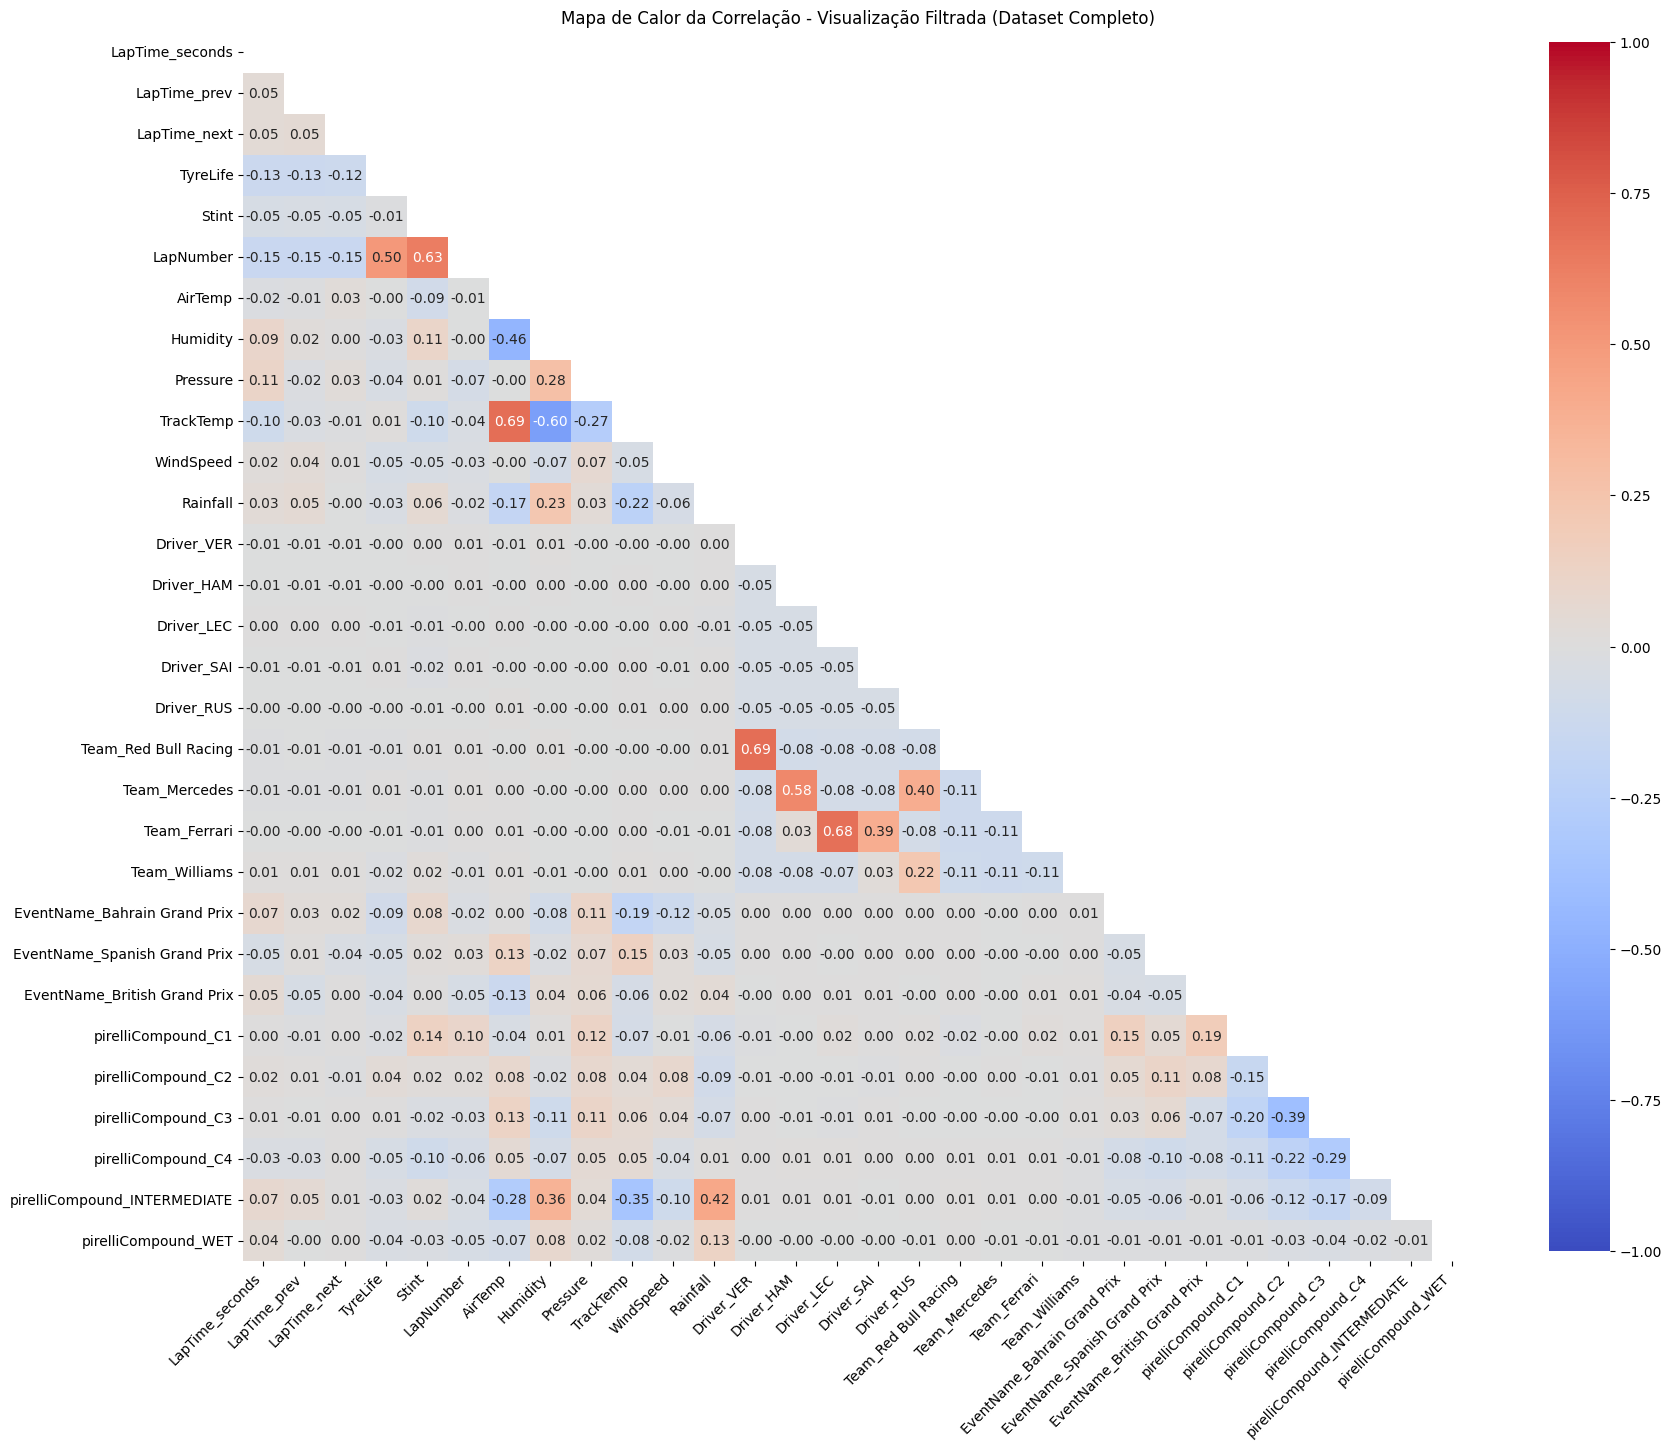

In [51]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. Combinar todas as voltas, clima e metadados ---
combined_laps_df = []
combined_weather_df = []
combined_event_df = []

for year, races in all_laps_data.items():
    for round_num, laps_df in races.items():
        laps_copy = laps_df.copy()
        laps_copy['Year'] = year
        laps_copy['RoundNumber'] = round_num
        
        event_meta = all_event_metadata.get(year, {}).get(round_num, {})
        laps_copy['EventName'] = event_meta.get('EventName', 'Unknown')
        laps_copy['Country'] = event_meta.get('Country', 'Unknown')
        laps_copy['City'] = event_meta.get('City', 'Unknown')
        laps_copy['EventDate'] = event_meta.get('Date', pd.NaT)
        
        combined_laps_df.append(laps_copy)

for year, races in all_weather_data.items():
    for round_num, weather_df in races.items():
        weather_copy = weather_df.copy()
        weather_copy['Year'] = year
        weather_copy['RoundNumber'] = round_num
        event_meta = all_event_metadata.get(year, {}).get(round_num, {})
        weather_copy['EventDate'] = event_meta.get('Date', pd.NaT)
        
        combined_weather_df.append(weather_copy)

combined_laps_df = pd.concat(combined_laps_df, ignore_index=True)
combined_weather_df = pd.concat(combined_weather_df, ignore_index=True)

print(f"✅ Total de voltas combinadas: {len(combined_laps_df)}")
print(f"✅ Total de registros meteorológicos combinados: {len(combined_weather_df)}")


combined_laps_df['IsAccurate'] = combined_laps_df.get('IsAccurate', True)
combined_laps_df['Year'] = combined_laps_df['Year'].astype(int)
combined_weather_df['Year'] = combined_weather_df['Year'].astype(int)


combined_laps_df = combined_laps_df.sort_values(['Year','Driver','Stint','LapNumber'])
combined_laps_df['LapTime_prev'] = combined_laps_df.groupby(['Year','Driver','Stint'])['LapTime_seconds'].shift(1)
combined_laps_df['LapTime_next'] = combined_laps_df.groupby(['Year','Driver','Stint'])['LapTime_seconds'].shift(-1)


# Converter EventDate para datetime
combined_laps_df['EventDate'] = pd.to_datetime(combined_laps_df['EventDate'], errors='coerce')
combined_weather_df['EventDate'] = pd.to_datetime(combined_weather_df['EventDate'], errors='coerce')

# Substituir NaT por uma data base padrão
base_date = pd.Timestamp('2000-01-01')
combined_laps_df['EventDate'] = combined_laps_df['EventDate'].fillna(base_date)
combined_weather_df['EventDate'] = combined_weather_df['EventDate'].fillna(base_date)

# Converter Time (timedelta) em datetime (somando ao EventDate)
combined_laps_df['DateTime'] = combined_laps_df['EventDate'] + combined_laps_df['Time']
combined_weather_df['DateTime'] = combined_weather_df['EventDate'] + combined_weather_df['Time']

# Reordenar
combined_laps_df = combined_laps_df.sort_values(['Year', 'RoundNumber', 'DateTime']).reset_index(drop=True)
combined_weather_df = combined_weather_df.sort_values(['Year', 'RoundNumber', 'DateTime']).reset_index(drop=True)

# Agora o merge funciona perfeitamente
seconds_margin = 60
laps_with_weather = pd.merge_asof(
    combined_laps_df,
    combined_weather_df,
    on='DateTime',
    by=['Year', 'RoundNumber'],
    direction='backward',
    tolerance=pd.Timedelta(seconds=seconds_margin)
)


print(f"✅ Merge concluído: {len(laps_with_weather)} voltas com dados climáticos associados.")


num_cols = [
    'LapTime_seconds', 'LapTime_prev', 'LapTime_next', 'Stint', 'TyreLife', 'LapNumber', 'Year',
    'AirTemp', 'Humidity', 'Pressure', 'Rainfall', 'TrackTemp', 'WindDirection', 'WindSpeed'
]

cat_cols = ['Driver', 'pirelliCompound', 'Team', 'EventName', 'Country', 'City']

# Verificar quais colunas realmente existem
num_cols = [c for c in num_cols if c in laps_with_weather.columns]

# Criar variáveis dummies
cat_dummies = pd.get_dummies(laps_with_weather[cat_cols], prefix=cat_cols, dummy_na=True)
num_df = laps_with_weather[num_cols].copy()

corr_df_full = pd.concat([num_df, cat_dummies], axis=1)
corr_df_clean = corr_df_full.dropna()

print(f"📊 Shape final do dataset para correlação: {corr_df_clean.shape}")


# --- 8. Gerar matriz de correlação (Pearson) ---
if corr_df_clean.empty or corr_df_clean.shape[1] <= 1:
    print("Nenhum dado completo disponível para gerar a matriz de correlação.")
else:
    corr_matrix = corr_df_clean.corr(method='pearson')
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

    # 🎯 Escolha o que vai aparecer no gráfico (sem afetar o cálculo)
    # Exemplo: mostrar apenas as variáveis numéricas + principais categóricas
    cols_to_display = [
        'LapTime_seconds', 'LapTime_prev', 'LapTime_next', 'TyreLife', 'Stint', 'LapNumber',
        'AirTemp', 'Humidity', 'Pressure', 'TrackTemp', 'WindSpeed', 'Rainfall',
        'Driver_VER', 'Driver_HAM', 'Driver_LEC', 'Driver_SAI', 'Driver_RUS',
        'Team_Red Bull Racing', 'Team_Mercedes', 'Team_Ferrari', 'Team_Williams',
        'EventName_Bahrain Grand Prix', 'EventName_Spanish Grand Prix',
        'EventName_British Grand Prix', 'pirelliCompound_C1', 'pirelliCompound_C2',
        'pirelliCompound_C3', 'pirelliCompound_C4', 'pirelliCompound_INTERMEDIATE',
        'pirelliCompound_WET'
    ]

    # Filtra apenas as colunas que realmente existem no dataset
    cols_to_display = [c for c in cols_to_display if c in corr_matrix.columns]
    corr_subset = corr_matrix.loc[cols_to_display, cols_to_display]

    plt.figure(figsize=(max(10, len(cols_to_display)*0.6), max(6, len(cols_to_display)*0.6)))
    ax = sns.heatmap(
        corr_subset, annot=True, cmap='coolwarm', fmt='.2f',
        vmin=-1, vmax=1, cbar_kws={'shrink':0.7}, square=True, mask=np.triu(np.ones_like(corr_subset, dtype=bool))
    )

    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    plt.title('Mapa de Calor da Correlação - Visualização Filtrada (Dataset Completo)')
    plt.tight_layout()
    plt.show()

